In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.optimize import curve_fit

In [11]:
def load_image(infilename) :
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype="uint8")
    return data

def rescale_images(images, scale):
    if type(scale) == float:
        return np.stack([cv2.resize(images[:,:,i], None, fx=scale, fy=scale) for i in range(images.shape[2])], 2)
    elif len(scale) == 2:
        return np.stack([cv2.resize(images[:,:,i], scale[::-1]) for i in range(images.shape[2])], 2)

def save_image(npdata, outfilename) :
    outimg = Image.fromarray(npdata, "RGB")
    outimg.save(outfilename)

def show_image(image):
    plt.ion()
    plt.imshow(image)
    plt.show()
    plt.pause(0.05)

def load_stylit_images(guidance_influence = 2.0, style = "style", channels = ("fullgi", "dirdif", "dirspc", "indirb"), scale=1.0):
    '''
    Outputs:
        - source: [:, :, :3] the place for stylized image
                  [:, :, 3:] the image with different shading considerations (e.g. diffuse, specular, ...)
        - target: [:, :, :3] simple sphere indicating the desired style
                  [:, :, 3:] simple sphere indicating different channels of lighting
        - channel_weights
    '''
    prefix = "images/source_"
    suffix = ".png"
    source = np.concatenate([load_image(prefix + channel + suffix) for channel in (style,) + channels], 2)
    prefix = "images/target_"
    target = np.concatenate([load_image(prefix + channel + suffix) for channel in channels], 2)
    output = np.zeros((target.shape[0],target.shape[1],3), dtype="uint8")
    target = np.concatenate((output, target), 2)
    channel_weights = np.array([1.0]*3 + [guidance_influence/float(len(channels))]*3*len(channels))
    if scale != 1.0:
        source = rescale_images(source, scale)
        target = rescale_images(target, scale)
    return source, target, channel_weights

In [12]:
# x,y specifies the pixel position of a patch center
def get_patch(image, x, y, patch_radius): 
    return image[int(y)-patch_radius : int(y)+patch_radius+1, int(x)-patch_radius : int(x)+patch_radius+1]

# ======================== initializations ===========================
def init_offsets_and_best_D(a_size, b_size, patch_size, b_mask):
    a_size = np.array(a_size[:2])-(patch_size-1)
    b_size = np.array(b_size[:2])-(patch_size-1)
    allowed_targets_y, allowed_targets_x = np.nonzero(b_mask == 0)
    selected_targets = np.random.randint(len(allowed_targets_x), size=a_size[:2])
    offsets_y = allowed_targets_y[selected_targets] - np.arange(a_size[0]).reshape((a_size[0],1))
    offsets_x = allowed_targets_x[selected_targets] - np.arange(a_size[1]).reshape((1,a_size[1]))
    best_d = np.zeros(a_size[:2])
    offsets_and_best_D = np.stack((offsets_y, offsets_x, best_d), 2)
    return offsets_and_best_D

def calculate_D(a, b, a_x, a_y, offset_x, offset_y, patch_radius, channel_weights):
    patch_a = get_patch(a, a_x, a_y, patch_radius)
    patch_b = get_patch(b, a_x+offset_x, a_y+offset_y, patch_radius)
    diff = patch_a - patch_b
    if channel_weights is None:
        return np.sum(diff * diff)
    else:
        return np.inner(np.sum(diff * diff, (0,1)), channel_weights)

def assign_initial_D(a, b, offsets, patch_radius, channel_weights, a_mask):
    height, width = offsets.shape[:2]
    for i in range(height):
        y = i + patch_radius
        for j in range(width):
            if a_mask is not None and a_mask[i, j]:
                continue
            x = j + patch_radius
            offsets[i,j,2] = calculate_D(a, b, x, y, offsets[i,j,1], offsets[i,j,0], patch_radius, channel_weights)

# ==================== iterations: propagate & random search ===========================     
def propagate(offsets, i, j, delta_i, delta_j, a, b, x, y, patch_radius, channel_weights, b_mask):
    neighbor_offset_y, neighbor_offset_x, neighbor_best_D = offsets[i + delta_i, j + delta_j]
    try:
        if b_mask[int(i + neighbor_offset_y), int(j + neighbor_offset_x)]: # Don't propagate offsets pointing to masked regions
            return
        D_using_neighbor_offset = calculate_D(a, b, x, y, neighbor_offset_x, neighbor_offset_y, patch_radius, channel_weights)  # (Can optimize this)
    except (ValueError, IndexError): # TODO: Handle this better
        return # Patch ends up outside B when using the neighbor's offset, so don't use it
    if D_using_neighbor_offset < offsets[i, j, 2]:
        offsets[i, j, :] = neighbor_offset_y, neighbor_offset_x, D_using_neighbor_offset

def random_search(offsets, i, j, b_offsets_size, search_windows, a, b, x, y, patch_radius, channel_weights, b_mask):
    min_offset = -np.array([i, j])
    max_offset = min_offset + b_offsets_size
    for window_radius in search_windows:
        min_window = np.maximum(min_offset, offsets[i, j, :2] - window_radius)
        max_window = np.minimum(max_offset, offsets[i, j, :2] + window_radius)
        try_offset_y = np.random.randint(min_window[0], max_window[0])
        try_offset_x = np.random.randint(min_window[1], max_window[1])
        while b_mask[int(i + try_offset_y), int(j + try_offset_x)]: # While offset leads to masked point, try again. May want to optimize this.
            try_offset_y = np.random.randint(min_window[0], max_window[0])
            try_offset_x = np.random.randint(min_window[1], max_window[1])
        try_D = calculate_D(a, b, x, y, try_offset_x, try_offset_y, patch_radius, channel_weights)
        if try_D < offsets[i, j, 2]:
            offsets[i, j, :] = try_offset_y, try_offset_x, try_D

# ============================= patchmatch =============================
def patchmatch(a, b, a_mask, b_mask, patchmatch_iterations = 6, patch_size = 5, 
               iteration_callback=None, scanline_callback_every_nth=50, 
               offsets=None, channel_weights=None):
    patch_radius = int((patch_size - 1) / 2)
    if offsets is None:
        offsets = init_offsets_and_best_D(a.shape, b.shape, patch_size, b_mask)
    elif a_mask is not None:
        original_offsets = offsets
        offsets = init_offsets_and_best_D(a.shape, b.shape, patch_size, b_mask)
        indices = np.nonzero(a_mask)
        offsets[indices] = original_offsets[indices]
    b_offsets_size = np.array(b.shape[:2])-(patch_size-1)
    height, width = offsets.shape[:2]
    max_search_radius = max(height, width)
    window_size_ratio = 0.5
    num_search_windows = 1 + int(-np.log(max_search_radius)/np.log(window_size_ratio)) # All possible windows larger than 1 pixel
    print("num_search_windows = " + str(num_search_windows))
    search_windows = [max_search_radius * window_size_ratio ** i for i in range(num_search_windows)]

    assign_initial_D(a, b, offsets, patch_radius, channel_weights, a_mask)

    for patchmatch_iteration in range(int(patchmatch_iterations/2)):
        # Right-down iteration
        for i in range(height):
            y = i + patch_radius
            for j in range(width):
                if a_mask is not None and a_mask[i,j]:
                    continue
                x = j + patch_radius
                # Propagation
                if j > 0:
                    propagate(offsets, i, j, 0, -1, a, b, x, y, patch_radius, channel_weights, b_mask)
                if i > 0:
                    propagate(offsets, i, j, -1, 0, a, b, x, y, patch_radius, channel_weights, b_mask)
                # Random search
                random_search(offsets, i, j, b_offsets_size, search_windows, a, b, x, y, patch_radius, channel_weights, b_mask)
            if i % scanline_callback_every_nth == 0:
                if iteration_callback is not None:
                    iteration_callback(patchmatch_iteration, i, offsets, a, b, patch_radius)
        # Left-up iteration
        for i in range(height-1,-1,-1):
            y = i + patch_radius
            for j in range(width-1,-1,-1):
                if a_mask is not None and a_mask[i,j]:
                    continue
                x = j + patch_radius
                # Propagation
                if j < width-1:
                    propagate(offsets, i, j, 0, 1, a, b, x, y, patch_radius, channel_weights, b_mask)
                if i < height-1:
                    propagate(offsets, i, j, 1, 0, a, b, x, y, patch_radius, channel_weights, b_mask)
                # Random search
                random_search(offsets, i, j, b_offsets_size, search_windows, a, b, x, y, patch_radius, channel_weights, b_mask)
            if i % scanline_callback_every_nth == 0:
                if iteration_callback is not None:
                    iteration_callback(patchmatch_iteration, i, offsets, a, b, patch_radius)
        if iteration_callback is not None:
            iteration_callback(patchmatch_iteration, None, offsets, a, b, patch_radius)
    return offsets

# ============== Reconstruct an image using the calculated offsets ===================
def reconstruct_image(offsets, a, b, patch_radius):
    reconstruction = np.zeros(a.shape)
    count = np.zeros(a.shape)
    height, width = offsets.shape[:2]
    for i in range(height):
        y = i + patch_radius
        for j in range(width):
            x = j + patch_radius
            patch = get_patch(b, x + offsets[i, j, 1], y + offsets[i, j, 0], patch_radius)
            reconstruction[y - patch_radius : y + patch_radius + 1, x - patch_radius : x + patch_radius + 1] += patch
            count[y - patch_radius: y + patch_radius + 1, x - patch_radius: x + patch_radius + 1] += 1
    reconstruction /= count
    return reconstruction.astype("uint8")

def iteration_callback(iteration, scanline, offsets, a, b, patch_radius):
    if scanline is None:
        print("Patchmatch iteration " + str(iteration))
    else:
        print("   Scanline " + str(scanline))
    show_image(reconstruct_image(offsets, a, b, patch_radius))


#if __name__ == "__main__":
#    a = load_image("test_a.jpg")
#    b = load_image("test_b.jpg")
#    patchmatch(a, b, iteration_callback=iteration_callback)

In [19]:
source, target, channel_weights = load_stylit_images()

num_pyramid_levels = 7 # 6
a_w, a_h = 400, 400
a = target
a_guides_original = np.copy(target[:,:,3:])
b_original = source
a = rescale_images(a, 0.5 ** (num_pyramid_levels - 1))
b = rescale_images(b_original, 0.5 ** (num_pyramid_levels - 1))

In [22]:
patch_size = 5  # [23, 13, 5][iteration]
patch_radius = int((patch_size - 1) / 2)
a_size = np.array(a.shape[:2]) - (patch_size - 1)
b_size = np.array(b.shape[:2]) - (patch_size - 1)
offsets = get_offsets_all_pointing_at_same_point(a_size) #np.zeros((a_size[0], a_size[1], 3))
num_target_patches = a_size[0] * a_size[1]

In [37]:
patch_radius = int((patch_size - 1) / 2)
offsets = init_offsets_and_best_D(a.shape, b.shape, patch_size, offsets[:,:,2] != 0)
a_mask = None
b_offsets_size = np.array(b.shape[:2])-(patch_size-1)
height, width = offsets.shape[:2]
max_search_radius = max(height, width)
window_size_ratio = 0.5
num_search_windows = 1 + int(-np.log(max_search_radius)/np.log(window_size_ratio)) # All possible windows larger than 1 pixel
print("num_search_windows = " + str(num_search_windows))
search_windows = [max_search_radius * window_size_ratio ** i for i in range(num_search_windows)]
assign_initial_D(a, b, offsets, patch_radius, channel_weights, a_mask)

num_search_windows = 4


In [43]:
print(a.shape)

(14, 19, 15)


In [8]:
def iteration_callback(iteration, scanline, offsets, a, b, patch_radius):
    if scanline is None:
        print("Patchmatch iteration " + str(iteration))
    else:
        print("   Scanline " + str(scanline))
    show_image(reconstruct_image(offsets, a[:,:,:3], b[:,:,:3], patch_radius))

def hyperbolic_function(x, a, b):
    return 1.0/(a - b * x)

# Returns the number of performed assignments
def perform_good_assignments(offsets, reversed_offsets, a_size, b_size):
    temp_offsets = np.zeros((a_size[0], a_size[1], 3))
    for i in range(b_size[0]):
        for j in range(b_size[1]):

            if temp_offsets[int(i+reversed_offsets[i,j,0]),int(j+reversed_offsets[i,j,1]),2] != 0: # If collision, keep the best assignment
                if reversed_offsets[i,j,2] < temp_offsets[int(i+reversed_offsets[i,j,0]),int(j+reversed_offsets[i,j,1]),2]:
                    temp_offsets[i + int(reversed_offsets[i, j, 0]), int(j + reversed_offsets[i, j, 1]), :2] = -reversed_offsets[i,j,:2]
                    temp_offsets[i + int(reversed_offsets[i, j, 0]), int(j + reversed_offsets[i, j, 1]), 2] = reversed_offsets[i,j,2]
            else:
                temp_offsets[i + int(reversed_offsets[i, j, 0]), int(j + reversed_offsets[i, j, 1]), :2] = -reversed_offsets[i, j,:2]
                temp_offsets[i + int(reversed_offsets[i, j, 0]), int(j + reversed_offsets[i, j, 1]), 2] = reversed_offsets[i, j, 2]

    i_indices, j_indices = np.nonzero(temp_offsets[:,:,2])
    errors = temp_offsets[i_indices, j_indices, 2]
    sort_indices = np.argsort(errors)
    sorted_errors = errors[sort_indices]
    sorted_i_indices = i_indices[sort_indices]
    sorted_j_indices = j_indices[sort_indices]
    
    # 
    if len(errors) > 5:

        # Normalize
        yvals = np.array(sorted_errors) - sorted_errors[0] # all - minimum
        D_range = yvals[-1] # maximum
        yvals = yvals / D_range # scale to [0,1]
        xvals = np.array(range(len(i_indices)))
        xvals = xvals/xvals[-1] # also scale to [0,1]

        plt.clf()
        plt.plot(xvals, yvals)

        #print(xvals)
        #print(yvals)
        (a,b),_ = curve_fit(hyperbolic_function, xvals, yvals, p0=(20, 19))
        plt.plot(xvals, hyperbolic_function(xvals, a, b))
        knee_point_x = -(1.0 / b) ** 0.5 + a / b # the point where derivative == 1
        knee_point_y = hyperbolic_function(knee_point_x, a, b)
        plt.scatter(knee_point_x, knee_point_y)
        knee_point_D = sorted_errors[0] + knee_point_y*D_range
        print("Knee point D at " + str(knee_point_D) + ", including " + str(int(knee_point_x*100)) + "% of the assignments")
        knee_point_index = int(knee_point_x * len(sorted_errors))
        plt.savefig("errors.png")
        plt.clf()
    else:
        knee_point_index = len(errors)

    # Perform the assignments that are before the knee point
    offsets[sorted_i_indices[:knee_point_index], sorted_j_indices[:knee_point_index], :] = temp_offsets[sorted_i_indices[:knee_point_index], sorted_j_indices[:knee_point_index], :]
    return knee_point_index

def get_offsets_all_pointing_at_same_point(a_size):
    offsets_y = np.zeros(a_size[:2]) - np.arange(a_size[0]).reshape((a_size[0], 1))
    offsets_x = np.zeros(a_size[:2]) - np.arange(a_size[1]).reshape((1, a_size[1]))
    best_d = np.zeros(a_size[:2])
    offsets_and_best_D = np.stack((offsets_y, offsets_x, best_d), 2)
    return offsets_and_best_D

num_search_windows = 11
Knee point D at 13371.386199533084, including 79% of the assignments
78% of patches assigned


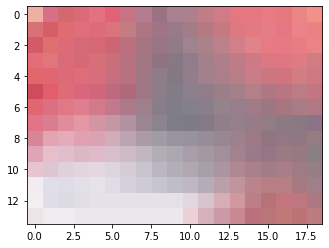

num_search_windows = 11
Knee point D at 13254.47557932862, including 72% of the assignments
94% of patches assigned


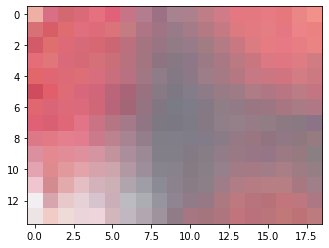

num_search_windows = 11
Knee point D at 14246.134938095205, including 86% of the assignments
98% of patches assigned


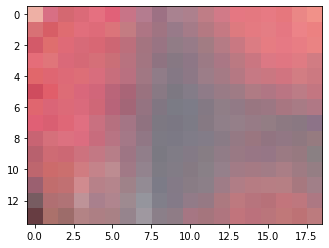

num_search_windows = 4
Solved last assignments with standard patchmatch


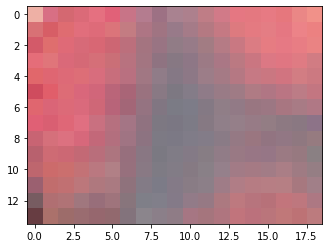

Wall time: 2h 41min 1s


In [9]:
%%time

if __name__ == "__main__":
    source, target, channel_weights = load_stylit_images()

    num_pyramid_levels = 7 # 6
    a_w, a_h = 400, 400
    a = target
    a_guides_original = np.copy(target[:,:,3:])
    b_original = source
    a = rescale_images(a, 0.5 ** (num_pyramid_levels - 1))


    for pyramid_level in range(num_pyramid_levels):
        b = rescale_images(b_original, 0.5 ** (num_pyramid_levels - 1 - pyramid_level))
        for iteration in range(1):
            patch_size = 5  # [23, 13, 5][iteration]
            if patch_size >= min(a_w, a_h, b.shape[0], b.shape[1]):
                continue
            patch_radius = int((patch_size - 1) / 2)
            a_size = np.array(a.shape[:2]) - (patch_size - 1)
            b_size = np.array(b.shape[:2]) - (patch_size - 1)
            offsets = get_offsets_all_pointing_at_same_point(a_size) #np.zeros((a_size[0], a_size[1], 3))
            num_target_patches = a_size[0] * a_size[1]
            num_assignments = 0
            while num_assignments/num_target_patches < 0.95:
                # Reversed NNF retrieval
                reversed_offsets = patchmatch(b, a, None, offsets[:,:,2] != 0, patchmatch_iterations=6, patch_size=patch_size,
                                     iteration_callback=None, offsets=None, channel_weights=channel_weights)
                # Sort potential patch assignments
                num_assignments += perform_good_assignments(offsets, reversed_offsets, a_size, b_size)
                print(str(int(100*num_assignments / num_target_patches)) + "% of patches assigned")
                show_image(reconstruct_image(offsets, a[:,:,:3], b[:,:,:3], patch_radius))
            if num_assignments != num_target_patches:
                # Solve remaining 5% with standard target-to-source patchmatch
                offsets = patchmatch(a, b, offsets[:,:,2] != 0, np.zeros(b_size), patchmatch_iterations=6, patch_size=patch_size,
                                     iteration_callback=None, offsets=offsets, channel_weights=channel_weights)
                print("Solved last assignments with standard patchmatch")
                show_image(reconstruct_image(offsets, a[:, :, :3], b[:, :, :3], patch_radius))
                plt.pause(1.0)
            a[:,:,:3] = reconstruct_image(offsets, a[:,:,:3], b[:,:,:3], patch_radius)

            # a[:,:,:3] = reconstruct_image(offsets, a[:,:,:3], b[:,:,:3], patch_radius)
            # print("Finished texture syntesis iteration " + str(iteration))
            # show_image(a[:,:,:3])
        save_image(a[:, :, :3], "output.png")
        rescaled_output = rescale_images(a[:,:,:3], 2.0)
        if pyramid_level < num_pyramid_levels-1:
            a = np.concatenate((rescaled_output, rescale_images(a_guides_original, rescaled_output.shape[:2])), 2)